In [1]:
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams['figure.dpi'] = 150
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchmetrics
import lightning as L

# from Definitions_TSRD
from Definitions_TSRD import T, DATA_PATH, MODELS_PATH, FIGURES_PATH, NUM_CLASSES, RANDOM_SEED
from Definitions_TSRD import TEACHER_TO_STUDENTS
from Definitions_TSRD import NORMALIZE_MEAN, NORMALIZE_STD
from Definitions_TSRD import FullNetwork, ReducedNetwork
from Definitions_TSRD import TeacherModel, StudentModel
from Definitions_TSRD import parse_teacher_str, parse_student_str
from Definitions_TSRD import recover_trained_weights
from Definitions_TSRD import get_TSRD_loaders, denormalize_imgs
print(f"T = {T}")
print(f"RANDOM_SEED = {RANDOM_SEED}")

# seeding
L.seed_everything(RANDOM_SEED, workers=True)
torch.manual_seed(RANDOM_SEED)

# device info
device = torch.device("cpu")
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
print(f"device = {device}")

Seed set to 42


T = 20
RANDOM_SEED = 42
device = mps


<font size=7><b>CPSC471 Project: Train Models (TSRD)</b></font>

**Ruomu (Felix) Zou**

**Model naming conventions:**
* `{F,R}T_temp{1,T}`: The *{full (larger architecture), reduced (smaller architecture)}* teacher model trained with cross-entropy with softmax temperature *{$1$, $T$ ($T>1$)}*. NOTE: Soft labels are ALWAYS generated with temperatuer $T$ regardless of teacher training temperature.
* `{F,R}S_temp{1,T}_from_{F,R}T_temp{1,T}`: Given a *{full, reduced}* teacher model trained at temperature *{$1$, $T$}*, generate soft labels at temperature $T$ and train a *{full, reduced}* student model at temperature *{$1$, $T$}*.
* Examples:
    * `FS_tempT_from_FT_tempT` represents the student model of the DD paper.
    * `RS_tempT_from_FT_temp1` represents the student model of traditional (Hinton) knowledge distillation.
    * `{F,R}S_temp1_from_{F,R}T_temp1` represents distillation where the only application of temperature is during soft label generation.
    * `{F,R}S_temp1_from_{F,R}T_tempT` represents something unconventional and weird.

# Constants and configurations:

In [2]:
# training-specific constants and configurations
BATCH_SIZE = 128 # same as DD paper
EPOCHS_training1_target1 = 80 # epochs for models trained at temperature 1 on targets generated at temperature 1
EPOCHS_trainingT_target1 = 80
EPOCHS_training1_targetT = 80
EPOCHS_trainingT_targetT = 80

# Helper Functions:

In [3]:
def train_and_save_teacher_model(str, data, ret=False):
    """Train and save a teacher model according to the specification in the argument string.

    Args:
        str: str of form '{F,R}T_temp{1,T}'.
        data: dataloader with RAW training data (hard labels).
        ret: whether to return the trained model too.
    Side effects:
        Saves trained teacher according to the specifications in `str` in MODELS_PATH.
    """
    # parse str
    architecture, temp = parse_teacher_str(str)

    # determine epochs to train for (teacher always uses targets with temperature 1)
    epochs = EPOCHS_training1_target1 if temp==1 else EPOCHS_trainingT_target1

    # initialize teacher model and trainer
    model = TeacherModel(architecture_class=architecture, training_temperature=temp)
    trainer = L.Trainer(max_epochs=epochs, deterministic=True, accelerator="mps", devices=1,
                        enable_checkpointing=False, logger=False,
                        enable_progress_bar=True, enable_model_summary=False)

    # fit and save
    trainer.fit(model=model, train_dataloaders=data)
    trainer.save_checkpoint(os.path.join(MODELS_PATH, f"{str}.ckpt"))

    # # TODO: delete
    # trainer.test(model, trainloader)
    # trainer.test(model, testloader)

    # optionally return
    if ret:
        return model

def train_and_save_student_model(str, data, ret=False):
    """Train and save a student model according to the specification in the argument string.

    NOTE: Assumes the teacher model specified in str has already been saved in MODELS_PATH!

    Args:
        str: str of form '{F,R}S_temp{1,T}_from_{F,R}T_temp{1,T}' specifying both teacher and student.
        data: dataloader with RAW training data (hard labels), soft labels will be generated with teacher.
        ret: whether to return the trained model too.
    Side effects:
        Saves trained student according to the specifications in `str` in MODELS_PATH.
    """
    # parse strings
    s_architecture, s_temp, t_architecture, t_temp = parse_student_str(str)

    # determine epochs to train for (student always uses targets with temperature T)
    epochs = EPOCHS_training1_targetT if s_temp==1 else EPOCHS_trainingT_targetT
    
    # get teacher model
    teacher_name = "_".join(str.split("_")[3:5])
    teacher_path = os.path.join(MODELS_PATH, f"{teacher_name}.ckpt")
    teacher_model = TeacherModel.load_from_checkpoint(teacher_path, architecture_class=t_architecture,
                                                      training_temperature=t_temp)
    teacher_model.eval()

    # initialize student model and trainer
    model = StudentModel(architecture_class=s_architecture, training_temperature=s_temp,
                         teacher_model=teacher_model)
    trainer = L.Trainer(max_epochs=epochs, deterministic=True, accelerator="mps", devices=1,
                        enable_checkpointing=False, logger=False,
                        enable_progress_bar=True, enable_model_summary=False)

    # fit and save
    trainer.fit(model=model, train_dataloaders=data)
    trainer.save_checkpoint(os.path.join(MODELS_PATH, f"{str}.ckpt"))

    # # TODO: delete
    # trainer.test(model, trainloader)
    # trainer.test(model, testloader)

    # optionally return
    if ret:
        return model

# Execution:

## Get data:

In [4]:
trainloader, testloader = get_TSRD_loaders(batch_size=BATCH_SIZE)

## Train all models:

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training teacher model RT_temp1.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training student model RS_temp1_from_RT_temp1.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training student model FS_temp1_from_RT_temp1.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training student model RS_tempT_from_RT_temp1.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training student model FS_tempT_from_RT_temp1.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training teacher model FT_temp1.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training student model RS_temp1_from_FT_temp1.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training student model FS_temp1_from_FT_temp1.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training student model RS_tempT_from_FT_temp1.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training student model FS_tempT_from_FT_temp1.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training teacher model RT_tempT.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training student model RS_temp1_from_RT_tempT.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training student model FS_temp1_from_RT_tempT.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training student model RS_tempT_from_RT_tempT.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training student model FS_tempT_from_RT_tempT.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training teacher model FT_tempT.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training student model RS_temp1_from_FT_tempT.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training student model FS_temp1_from_FT_tempT.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training student model RS_tempT_from_FT_tempT.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training student model FS_tempT_from_FT_tempT.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.


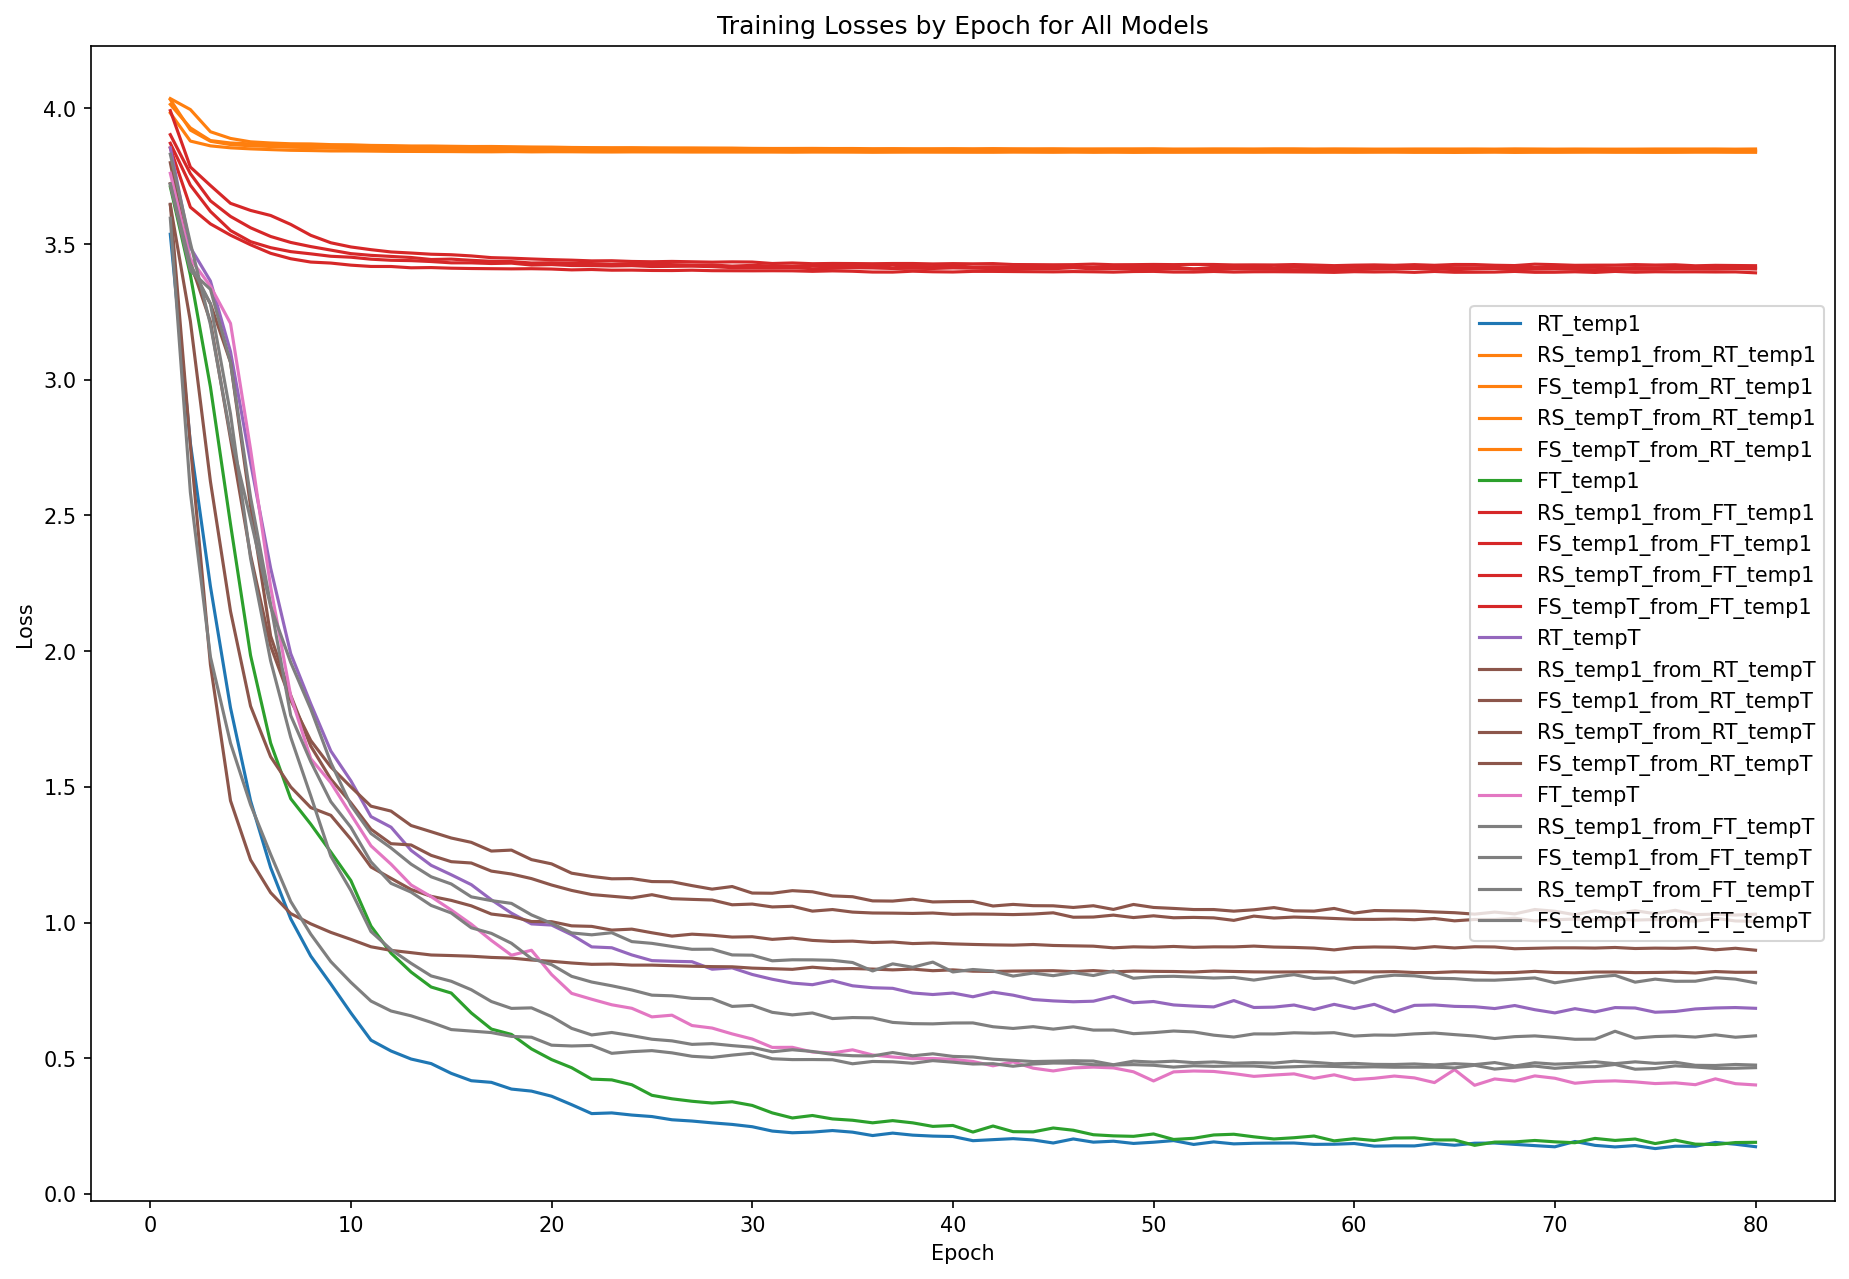

In [5]:
# configure plot for loss curves
fig, ax = plt.subplots(figsize=(15, 10))

# loop through all teacher/student models
colors = list(matplotlib.colors.TABLEAU_COLORS.keys())
color_counter = 0
for teacher, students in TEACHER_TO_STUDENTS.items():
    # first train and save teacher model
    print(f"Training teacher model {teacher}.")
    teacher_model = train_and_save_teacher_model(teacher, trainloader, ret=True)
    iterations = np.arange(start=1, stop=len(teacher_model.epoch_losses)+1, step=1)
    ax.plot(iterations, teacher_model.epoch_losses, label=teacher, color=colors[color_counter])

    # go to next color for students
    color_counter += 1

    # iterate through students and train and save
    for student in students:
        print(f"Training student model {student}.")
        student_model = train_and_save_student_model(student, trainloader, ret=True)
        iterations = np.arange(start=1, stop=len(student_model.epoch_losses)+1, step=1)
        ax.plot(iterations, student_model.epoch_losses, label=student, color=colors[color_counter])

    # go to next color for next teacher
    color_counter += 1

# plot
ax.set_title("Training Losses by Epoch for All Models")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.savefig(os.path.join(FIGURES_PATH, "TrainingLosses.png"))
plt.show();